# Frequency Domain Analysis

In [170]:
import sys
import os
sys.path.append(os.path.abspath(".."))
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [171]:
from utils.libaries import *
from utils.data_loading import findFiles,LoadDataSignals
from utils.global_parameters import *
from Data_Denoising.data_denoising import *
from Data_Denoising.time_synchronization import *
from Data_Denoising.moving_average_filter import *
from Data_Denoising.derivative_filtering import apply_improved_derivative_filter
from Data_Denoising.dc_offset_removal import *
from plotting_module.signal_plot import *
from Data_Denoising.bandpass_filtering import *
from waveform_detection.detect_waveform import *
from waveform_detection.pan_algorithm import *
from time_of_flight_calculation.zero_crossings import *
from utils.libaries import *
from utils.data_loading import findFiles,LoadDataSignals
from utils.global_parameters import *
from Data_Denoising.data_denoising import *
from Data_Denoising.time_synchronization import *
from Data_Denoising.moving_average_filter import *
from Data_Denoising.derivative_filtering import apply_improved_derivative_filter
from Data_Denoising.dc_offset_removal import *
from plotting_module.signal_plot import *
from Data_Denoising.bandpass_filtering import *
from waveform_detection.detect_waveform import *
from waveform_detection.pan_algorithm import *
from time_of_flight_calculation.zero_crossings import *
from time_of_flight_calculation.tof import *
from time_of_flight_calculation.velocity import *
from time_of_flight_calculation.sugar_velocity_relationship import *
from time_of_flight_calculation.correlation import *
from plotting_module.crosscorrelation_plot import *


In [172]:
waveforms=["sin","squ"]
periods= ["1","5","9"]

expected_waveform= waveforms[1]
expected_periods= periods[2]

unique_file_list= findFiles(expected_waveform,expected_periods,sample_number=1)
unique_file_list

['/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025/144000mg/28thmaynewsetup1percentage25DegreeTemperatureMarch-ram-WaterSugar_mid_solution-144000mg-squ9-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025/108000mg/28thmaynewsetup1percentage25DegreeTemperatureMarch-ram-WaterSugar_mid_solution-108000mg-squ9-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025/36000mg/2025may28-ram-WaterSugar_mid_solution-36000mg-squ9-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025/00000mg/2025may28-ram-WaterSugar_mid_solution-0mg-squ9-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal p

In [173]:
raw,Concentration,actual_waveform,periods=LoadDataSignals(unique_file_list[2],time_axis_start=0,time_axis_end=16000)

raw.shape


(100, 2, 16000)

In [174]:
transmit, receive= dc_offset_removal(raw)

DC Offset Removal - Transmit: (100, 16000)  | Receive: (100, 16000)


In [175]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

def plot_signal_fft(signal, fs):
    N = len(signal)
    yf = np.abs(fft(signal))
    xf = fftfreq(N, 1/fs)

    # One-sided spectrum
    plt.plot(xf[:N//2]/1e6, yf[:N//2])
    plt.title("FFT Spectrum")
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.show()


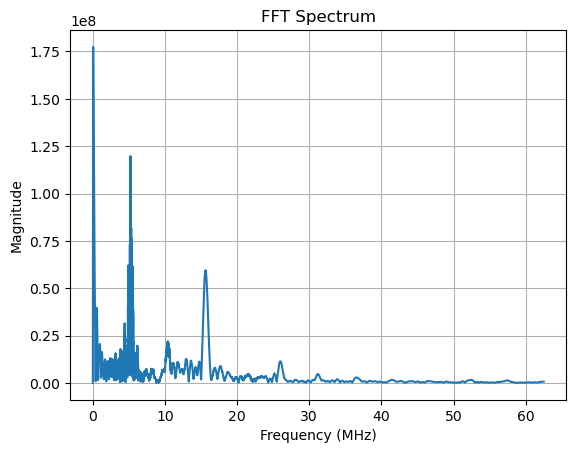

In [176]:
fs = 125e6  # Sampling rate: 125 MHz
plot_signal_fft(receive[0,:], fs)
